# Packages & Imports

In [ ]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install plotnine

In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from helios import intensity_estimation

# Dataset and Subdivision

In [2]:
# reading the 04-05 data from the csv
df = pd.read_csv('dataset/Solar_flare_RHESSI_2004_05.csv')

# changing the month values for the year 2005 (1 = 13, 2 = 14, etc.) to make subdivision simpler later on
# in rows where the year value is 2005, add 12 to the month value and replace the old month value
df['month'] = np.where((df['year'] == 2005), df['month'] + 12, df['month'])

# list that will hold sets of 4 with a two month overlap
dfs = []

# grouping the data frame by month nummber
df_m = df.groupby(['month'])

# looping starting at i = 4, in steps of 2, while i < 25
# creates an overlap of two months between subsets
for i in range(4, 25, 2):
    # get groups for i - 3th, i - 2th, i - 1th, and ith months, 
    # concatenate them into a single data frame, then append this to the dfs list
    dfs.append(pd.concat([df_m.get_group(i - 3), df_m.get_group(i - 2), df_m.get_group(i - 1), df_m.get_group(i)]))

# Hotspot Discovery

## Finding Thresholds `d1` and `d2`

In [ ]:
def thresholds(data):
    """For each subset of data, get the potential threshold values for hotspots"""
    
    ticks = []

    # loop through each subset
    for set in data:
        # append the potential threshold values to the ticks list
        # a level value of [0, 0.25, 0.5, 0.75, 1] will return 5 intensity values where each
        # corresponds with a probability mass of 0%, 25%, and so on
        ticks.append(intensity_estimation(set, plot=True, levels=[0, 0.25, 0.5, 0.75, 1]))
    
    # return the potential threshold values
    return ticks

# numpy mean will get the element-wise mean for all the potential threshold values
# from here, we can select the d1 and d2 threshold values from this list, like t[2] for the med
# hotspots and t[3] for the intense hotspots or something
t = np.mean(thresholds(dfs), axis=0)

d2 = t[2]
d1 = t[3]

## Time Series Using `d1` and `d2` Threshold values

c:\Users\bs\source\data_science\helios-group-project\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bs\source\data_science\helios-group-project\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


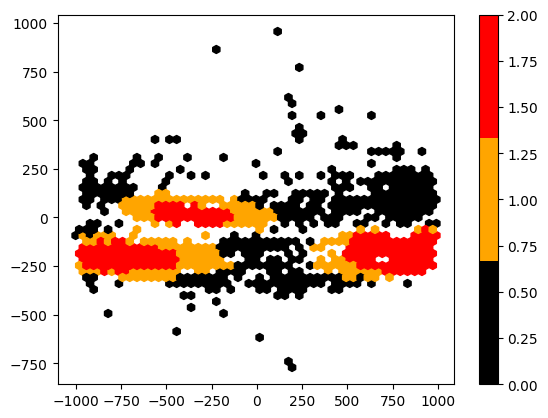

In [38]:
"""Testing for hotspot plots"""

flares = dfs[2]

intesities = intensity_estimation(flares)

flares['intensity.estimation'] = intesities

intensity_classifications = np.empty(shape=len(flares), dtype=np.str_)

flares['intensity.class'] = intensity_classifications


flares['intensity.class'] = np.where((flares['intensity.estimation'] < d2 ), "0", flares['intensity.class'])
flares['intensity.class'] = np.where(((flares['intensity.estimation'] >= d2) & (flares['intensity.estimation'] < d1)), "1", flares['intensity.class'] )
flares['intensity.class'] = np.where((flares['intensity.estimation'] >= d1 ), "2", flares['intensity.class'])

flares['intensity.class'] = flares['intensity.class'].astype('int32')


colors = ['black','orange','red']

plt.figure()
plt.hexbin(x=flares['x.pos.asec'].values.flatten(), y=flares['y.pos.asec'].values.flatten(), C=flares['intensity.class'].values.flatten(), cmap=matplotlib.colors.ListedColormap(colors), gridsize=50)
plt.colorbar()
plt.savefig('./output/bins.png')
plt.show()